# Goal

* re-plotting SIPSim validation plot (example of OTU distribution in control vs labeled-treatment gradient)

# Setting variables

In [1]:
#workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation/'
#genomeDir = '/var/seq_data/ncbi_db/genome/Jan2016/bac_complete_spec-rep1_rn/'
#R_dir = '/home/nick/notebook/SIPSim/lib/R/'
#figureDir = '/home/nick/notebook/SIPSim/figures/bac_genome_n1147/'
workDir = '/ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/validation/'

# Init

In [168]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

In [169]:
# BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp50 = 0.5 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66
# cutoff to call real incoporator
BD_shift.cut = 0.001

# Plotting abundance distributions (paper figure)

## Loading OTU abundances

In [170]:
# loading file
F = file.path(workDir, 'OTU_n2_abs1e9.txt')
df.abs = read.delim(F, sep='\t')
F = file.path(workDir, 'OTU_n2_abs1e9_PCR_subNorm.txt')
df.sub = read.delim(F, sep='\t')

lib.reval = c('1' = 'control',
              '2' = 'treatment')

df.abs = mutate(df.abs, library = plyr::revalue(as.character(library), lib.reval))
df.sub = mutate(df.sub, library = plyr::revalue(as.character(library), lib.reval))

## Loading incorp identity

* Which taxa are actually incorporators

In [171]:
F = file.path(workDir, 'ampFrags_BD-shift.txt')
df.shift = read.delim(F, sep='\t') %>%
    filter(library == 2) %>%
    mutate(true_incorp = median >= BD_shift.cut)

# status
df.shift$median %>% table %>% print
df.shift$true_incorp %>% table %>% print
df.shift %>% dim %>% print
df.shift %>% head(n=3)

.
    0 0.036 
  993   109 
.
FALSE  TRUE 
  993   109 
[1] 1102    9


library,taxon,min,q25,mean,median,q75,max,true_incorp
2,Acaryochloris_marina_MBIC11017,0.036,0.036,0.036,0.036,0.036,0.036,TRUE
2,Acetobacter_pasteurianus_IFO_3283-03,0.000,0.000,0.000,0.000,0.000,0.000,FALSE
2,Acetobacterium_woodii_DSM_1030,0.000,0.000,0.000,0.000,0.000,0.000,FALSE


## Formatting

In [172]:
# absolute abundances
df.abs %>% dim %>% print
df.abs = df.abs %>%
    left_join(df.shift %>% dplyr::select(taxon, true_incorp), 
               c('taxon')) %>%
    mutate(true_incorp = ifelse(is.na(true_incorp), FALSE, true_incorp),
           alpha = ifelse(true_incorp==TRUE, 0.5, 0.15))
df.abs %>% dim %>% print

# subsampled abundances
df.sub %>% dim %>% print
df.sub = df.sub %>%
    left_join(df.shift %>% dplyr::select(taxon, true_incorp), 
               c('taxon')) %>%
    mutate(true_incorp = ifelse(is.na(true_incorp), FALSE, true_incorp),
           alpha = ifelse(true_incorp==TRUE, 0.5, 0.15))
df.sub %>% dim %>% print

# status
df.abs %>% head(n=3) %>% print
df.sub %>% head(n=3) %>% print

[1] 64232     8


Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factors with different levels, coercing to character vector”

[1] 64232    10
[1] 64232     8


Warning message in left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y):
“joining factors with different levels, coercing to character vector”

[1] 64232    10
  library                          taxon    fraction BD_min BD_mid BD_max count
1 control Acaryochloris_marina_MBIC11017  -inf-1.673   -Inf  1.672  1.672    34
2 control Acaryochloris_marina_MBIC11017 1.673-1.675  1.673  1.674  1.675     1
3 control Acaryochloris_marina_MBIC11017 1.675-1.680  1.675  1.677  1.680     8
     rel_abund true_incorp alpha
1 1.377578e-05        TRUE   0.5
2 5.267760e-06        TRUE   0.5
3 1.528920e-05        TRUE   0.5
  library    fraction                          taxon BD_min BD_mid BD_max count
1 control  -inf-1.673 Acaryochloris_marina_MBIC11017   -Inf  1.672  1.672     0
2 control 1.673-1.675 Acaryochloris_marina_MBIC11017  1.673  1.674  1.675     0
3 control 1.675-1.680 Acaryochloris_marina_MBIC11017  1.675  1.677  1.680     0
  rel_abund true_incorp alpha
1         0        TRUE   0.5
2         0        TRUE   0.5
3         0        TRUE   0.5


In [173]:
# creating relative abundancs for df.sub
df.sub.rel = df.sub %>%
    group_by(library, fraction) %>%
    mutate(total_count = sum(count)) %>%
    ungroup() %>%
    mutate(count = count / total_count) %>%
    dplyr::select(-total_count)

df.sub.rel %>% head(n=3)

library,fraction,taxon,BD_min,BD_mid,BD_max,count,rel_abund,true_incorp,alpha
control,-inf-1.673,Acaryochloris_marina_MBIC11017,-Inf,1.672,1.672,0,0,TRUE,0.5
control,1.673-1.675,Acaryochloris_marina_MBIC11017,1.673,1.674,1.675,0,0,TRUE,0.5
control,1.675-1.680,Acaryochloris_marina_MBIC11017,1.675,1.677,1.680,0,0,TRUE,0.5


## Plotting

In [175]:
x.lab = expression(paste('Buoyant density (g ml' ^ '-1', ')'))

Warning message:
“Width not defined. Set with `position_dodge(width = ?)`”Warning message:
“Width not defined. Set with `position_dodge(width = ?)`”

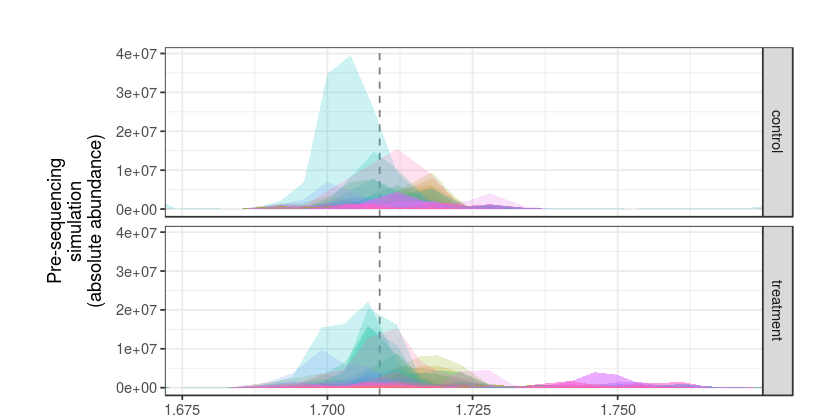

In [178]:
# plotting absolute abundances
p = ggplot(df.abs, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    scale_x_continuous(expand=c(0,0)) +
    labs(x='Buoyant density') +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        axis.title.y = element_text(vjust=1),        
        axis.title.x = element_blank(),
        legend.position = 'none',
        plot.margin=unit(c(1,1,0.1,1), "cm")
    )
p1 = p + 
    geom_area(alpha=0.2, stat='identity', position='dodge') +
    geom_area(data = df.abs %>% filter(true_incorp == TRUE),
              alpha=0.5, stat='identity', position='dodge') +
    labs(y='Pre-sequencing\nsimulation\n(absolute abundance)')

options(repr.plot.width=7, repr.plot.height=3.5)
plot(p1)

Warning message:
“Width not defined. Set with `position_dodge(width = ?)`”Warning message:
“Width not defined. Set with `position_dodge(width = ?)`”

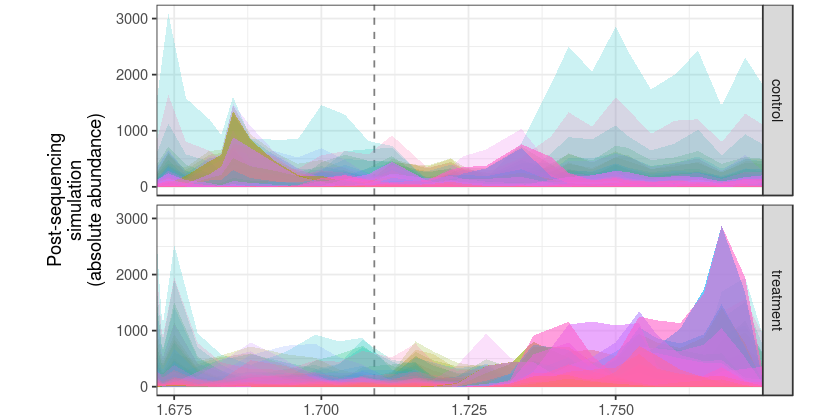

In [195]:
# plotting absolute abundances of subsampled taxa
p = ggplot(df.sub, aes(BD_mid, count, fill=taxon)) +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    scale_x_continuous(expand=c(0,0)) +
    labs(x=x.lab) +
    facet_grid(library ~ .) +
    theme_bw() +
    theme( 
        legend.position = 'none'
    )
p2 = p + 
    geom_area(alpha=0.2, stat='identity', position='dodge') +
    geom_area(data = df.sub %>% filter(true_incorp == TRUE),
              alpha=0.5, stat='identity', position='dodge') +
    labs(y='Post-sequencing\nsimulation\n(absolute abundance)') +
    theme(
          axis.title.y = element_text(vjust=1),        
          axis.title.x = element_blank(),
          plot.margin=unit(c(0.1,1,0.1,1), "cm")
         )

options(repr.plot.width=7, repr.plot.height=3.5)
plot(p2)

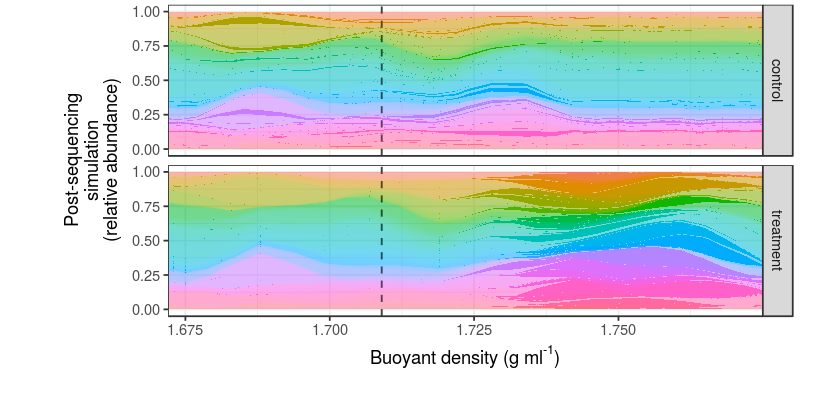

In [198]:
# plotting relative abundances of subsampled taxa
p3 = p + 
    geom_area(alpha=0.5, stat='identity', position='fill') +
    geom_area(aes(alpha=alpha), stat='identity', position='fill') +
    #geom_line(aes(alpha=true_incorp), color='black', size=0.2, position='fill') +
    geom_vline(xintercept=c(BD.GCp50), linetype='dashed', alpha=0.5) +
    labs(y='Post-sequencing\nsimulation\n(relative abundance)') +
    theme(
          axis.title.y = element_text(vjust=1),
          plot.margin=unit(c(0.1,1,1,1.35), "cm")
        )

options(repr.plot.width=7, repr.plot.height=3.5)
plot(p3)

Warning message:
“Width not defined. Set with `position_dodge(width = ?)`”Warning message:
“Width not defined. Set with `position_dodge(width = ?)`”Warning message:
“Width not defined. Set with `position_dodge(width = ?)`”Warning message:
“Width not defined. Set with `position_dodge(width = ?)`”

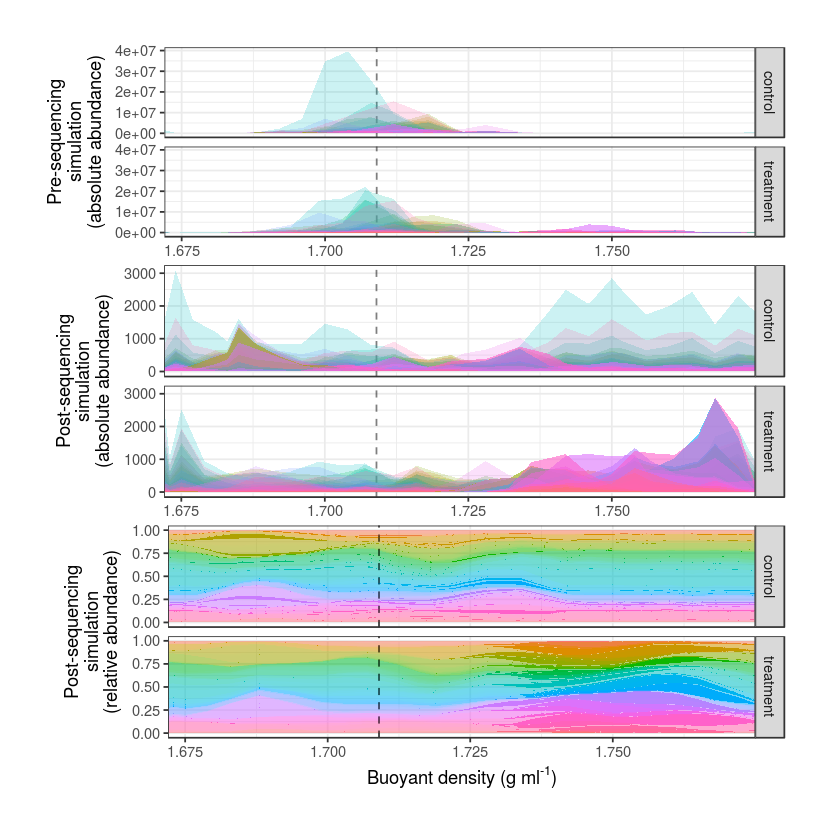

In [199]:
# combining plots
p.comb = cowplot::ggdraw() +
    geom_rect(aes(xmin=0, ymin=0, xmax=1, ymax=1), fill='white') +
    cowplot::draw_plot(p1, 0.0, 0.69, 0.99, 0.31) +
    cowplot::draw_plot(p2, 0.01, 0.38, 0.98, 0.31) +
    cowplot::draw_plot(p3, 0.0, 0.0, 0.99, 0.38) 

options(repr.plot.width=7, repr.plot.height=7)
plot(p.comb)

### Saving figures

In [202]:
F = file.path(workDir, 'abundDist_example.pdf')
ggsave(F, p.comb, width=9, height=9)
cat('File written:', F, '\n')

File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/validation//abundDist_example.pdf 


In [203]:
F = file.path(workDir, 'abundDist_example.tiff')
ggsave(F, p.comb, width=9, height=9, dpi=300)
cat('File written:', F, '\n')

File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/validation//abundDist_example.tiff 


In [204]:
F = file.path(workDir, 'abundDist_example.png')
ggsave(F, p.comb, width=9, height=9, dpi=250)
cat('File written:', F, '\n')

File written: /ebio/abt3_projects/methanogen_host_evo/SIPSim_pt2/data/bac_genome1147/validation//abundDist_example.png 
